In [77]:
%matplotlib inline 
import os
import scipy
from scipy.special import j1
import numpy as np
import healpy as hp
import math as mth
import time

from scipy import interpolate
from scipy.special import j0
from scipy.integrate import quad
from scipy.integrate import trapz
from astropy.io import fits

from scipy.interpolate import CubicSpline

import matplotlib.pyplot as plt 
import io


#DEFINE JINC FUNCTION

def jinc(x):

    if x == 0.0:
        return 0.5
    return j1(x) / x

#DEFINE GAUSSIAN FUNCTION
def gaussian(theta, delta_theta):   # delta_theta is FWHM. 

    sigma=delta_theta/np.sqrt(8*np.log(2))
    coeff=1/sigma*(np.sqrt(2*np.pi))

    gauss=coeff*np.exp(-np.power((theta/sigma), 2.)/2.)

    return gauss




def decibel(x):
    return 10*np.log10(x)


def E_r(rho,sigma):
    return np.exp(-0.5*(rho/sigma)**2)


def deg2rad(deg):
    return deg*(np.pi/180.)


def freq2lamda(frequency):
    c=299792458
    return c/(frequency*1e6)

def generate_harper_beam(theta,freq):




    lamda=freq2lamda(freq)    # compute wavelength at a given frequency
    D=13.5                    # MeerKAT dish diameter
    delta_theta=lamda/D       # FWHM
    #print('delta_theta[radians]:',delta_theta,'in degs:%5.3f degrees'%np.degrees(delta_theta))


    sigma=(1/(2*delta_theta)) # 0.5*


    rho=np.linspace(0,sigma,num=1e4)

    deno=E_r(rho,sigma)*rho         #  denominator function of equation 4  

    integral_deno=trapz(deno,rho)   #computing the integral of the denominator of equation 4 

    sine=np.sin(deg2rad(theta))

    num_integrand=E_r(rho,sigma)*rho*j0(2.0*np.pi*sine*rho)

    Beam_theta=(np.abs(((trapz(num_integrand,rho)/integral_deno)))**2)


    return Beam_theta



def create_Beam(theta,nu,Amp,beam,T_p):
    
    # Creates pixelised beam on a healpix map by computing the jinc function for each theta angle
    #outlining intrinsic properties of the beam model see eqn:4 of beam_ps.pdf

    speed_of_light=299792458   # speed of light in m/s
    first_zero_of_jinc_function=3.8317 #first zero of jinc function : position of the first null 
    dish_diameter=13.5 #*2 # diameter of telescope dish in meters (m)
    frequency=nu*1e6   #frequency in hertz (Hz)
    #frequency=850*1e6
    #adding ripple
    T=2*np.pi/(float(T_p)*1e6) #angular frequency / cycle of the wave is 20 MHz

    Amp=Amp/60.  #arcmin to degrees   
    sine_wave=(Amp*mth.sin(frequency*T))

    fwhm=np.degrees((speed_of_light/frequency)/dish_diameter) # *(1+sine_wave))  # computing the beam size
    #fwhm=0.65*2.0 # convolving point sources with 1 degree beam

    delta_theta=fwhm + sine_wave  #fwhm in degrees    #compute beam size : FWHM   .. e.q.    on beam_ps.pdf


    if (beam =='gauss'):
        

        if theta>90.:
            
            bim=0.0


        else:
            
            bim=gaussian(theta,delta_theta)/gaussian(0.0,delta_theta)    # sigma==delta theta

    elif(beam =='jinc'):
        

        if theta>90.:
            
            bim=0.0

        else:
            
               #consider delta_theta/2 case
            bim=jinc(3.223*(theta/(delta_theta)))**2 /jinc(0)**2


    elif(beam =='harper'):
        

        if(theta<=90.0):
            
            #start=time.time()
            bim=generate_harper_beam(theta,nu)
                                #end=time.time()
            #print('duration to compute beam value per theta %5.3f'%(end-start))
            #print('theta :',theta,'bim  :',bim)
        else:
            
            bim=0.0
            #print('theta :',theta,'bim  :',bim)

    else:
        
        print('Unkown beam option supplied')
        print('Permissible beam options are:- jinc,gauss or harper')


    return bim







In [39]:
freq=950  #(MHz)-frequency
Amp=0.3   #(Arcmins)-Amplitude of simulated ripple
T_p=20.   #(MHz)-wavelength of ripple


In [47]:
# JINC

theta=np.arange(0,90,0.01)
beam='jinc'

Jinc_beam=np.zeros((len(theta)))

for i in range(len(theta)):
    
    Jinc_beam[i]=create_Beam(theta[i],freq,Amp,beam,T_p)


In [48]:
# GAUSS 
beam='gauss'
Gauss_beam=np.zeros(len(theta))

for j in range(len(theta)):
    
    Gauss_beam[j]=create_Beam(theta[j],freq,Amp,beam,T_p)


In [49]:
# HARPER
beam='harper'
harper_beam=np.zeros(len(theta))

for k in range(len(theta)):
    
    harper_beam[k]=create_Beam(theta[k],freq,Amp,beam,T_p)




/Users/Siyambonga/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:73: DeprecationWarning: object of type <type 'float'> cannot be safely interpreted as an integer.


/Users/Siyambonga/anaconda2/lib/python2.7/site-packages/ipykernel_launcher.py:44: RuntimeWarning: divide by zero encountered in log10


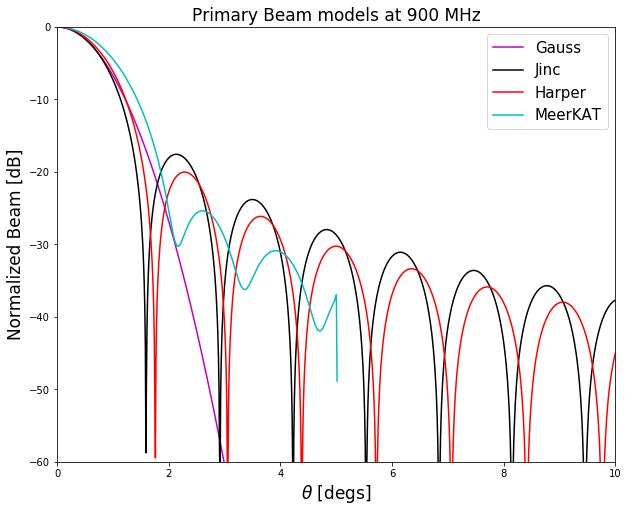

In [95]:
#MEERKAT

# read in data file 

theta_i,meerKAT_beam=np.loadtxt('Radially_averaged_beam_900MHz.txt',usecols=(0,1),unpack=True)

plt.figure(1,figsize=(10,8))
plt.title('Primary Beam models at 900 MHz',fontsize=17)
plt.plot(theta,decibel(Gauss_beam),'m',label='Gauss')
plt.plot(theta,decibel(Jinc_beam),'k',label='Jinc')
plt.plot(theta,decibel(harper_beam/harper_beam[0]),'r',label='Harper')
plt.plot(theta_i,decibel(meerKAT_beam/meerKAT_beam[0]),'c',label='MeerKAT')
plt.legend(fontsize=15)
plt.xlim(0,10)
plt.ylim(-60,0)
plt.xlabel(r'$\theta$ [degs]',fontsize=17)
plt.ylabel('Normalized Beam [dB]',fontsize=17)
plt.show()
plt.close()
